In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import dalex as dx
import scipy
import optuna

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostClassifier
from statsmodels.tools.tools import add_constant
from matplotlib import style
from optuna.integration import CatBoostPruningCallback

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [2]:
#loading data
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

#setting y to 0-1 binary variable
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 0, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 1, inplace=True)

#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag'].astype(float)

#used stratified, because of the distribution of y (it's skewed)
idx_train, idx_rest = train_test_split(X.index, stratify=y, random_state=999, test_size=0.3)

X_train, X_rest = X.loc[idx_train], X.loc[idx_rest]
y_train, y_rest = y[idx_train], y[idx_rest]

idx_test, idx_val = train_test_split(X_rest.index, stratify=y_rest, random_state=999, test_size=0.5)

X_test, X_val = X.loc[idx_test], X.loc[idx_val]
y_test, y_val = y[idx_test], y[idx_val]

#selecting numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns

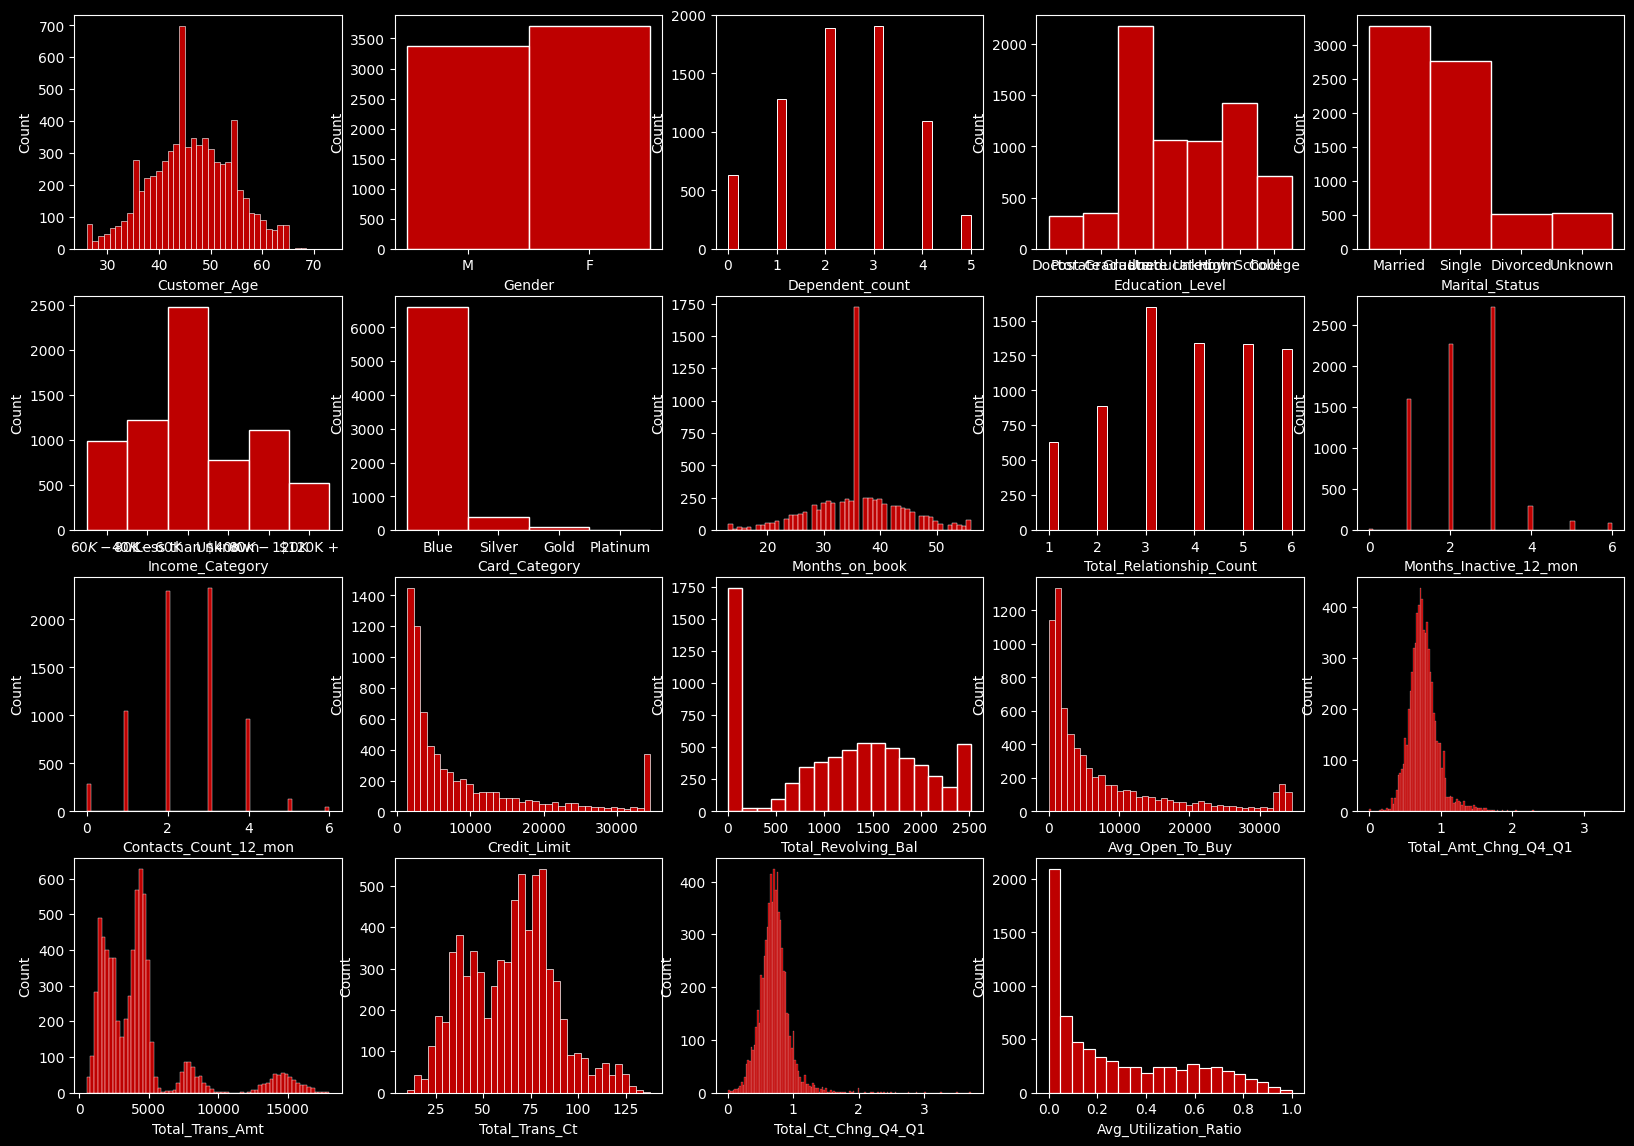

In [3]:
#displaying distribution of the data

plt.figure(figsize=(20,14))
k=1
for i in X_train.columns:
    plt.subplot(4,5,k)
    sns.histplot(X_train[i])
    k+=1

plt.show()

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_val = encoder.transform(X_val[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_val.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_val = pd.concat([X_val, one_hot_encoded_val], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)

In [5]:
#building model
model = CatBoostClassifier(verbose=False)
model_fitted = model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [6]:
#initializing explainer 

model_exp = dx.Explainer(model_fitted, X_train, y_train, label='CBC')

Preparation of a new explainer is initiated

  -> data              : 7088 rows 37 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7088 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : CBC
  -> predict function  : <function yhat_proba_default at 0x000001E21115E050> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.9e-06, mean = 0.161, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.819, mean = 4.41e-05, max = 0.794
  -> model_info        : package catboost

A new explainer has been created!


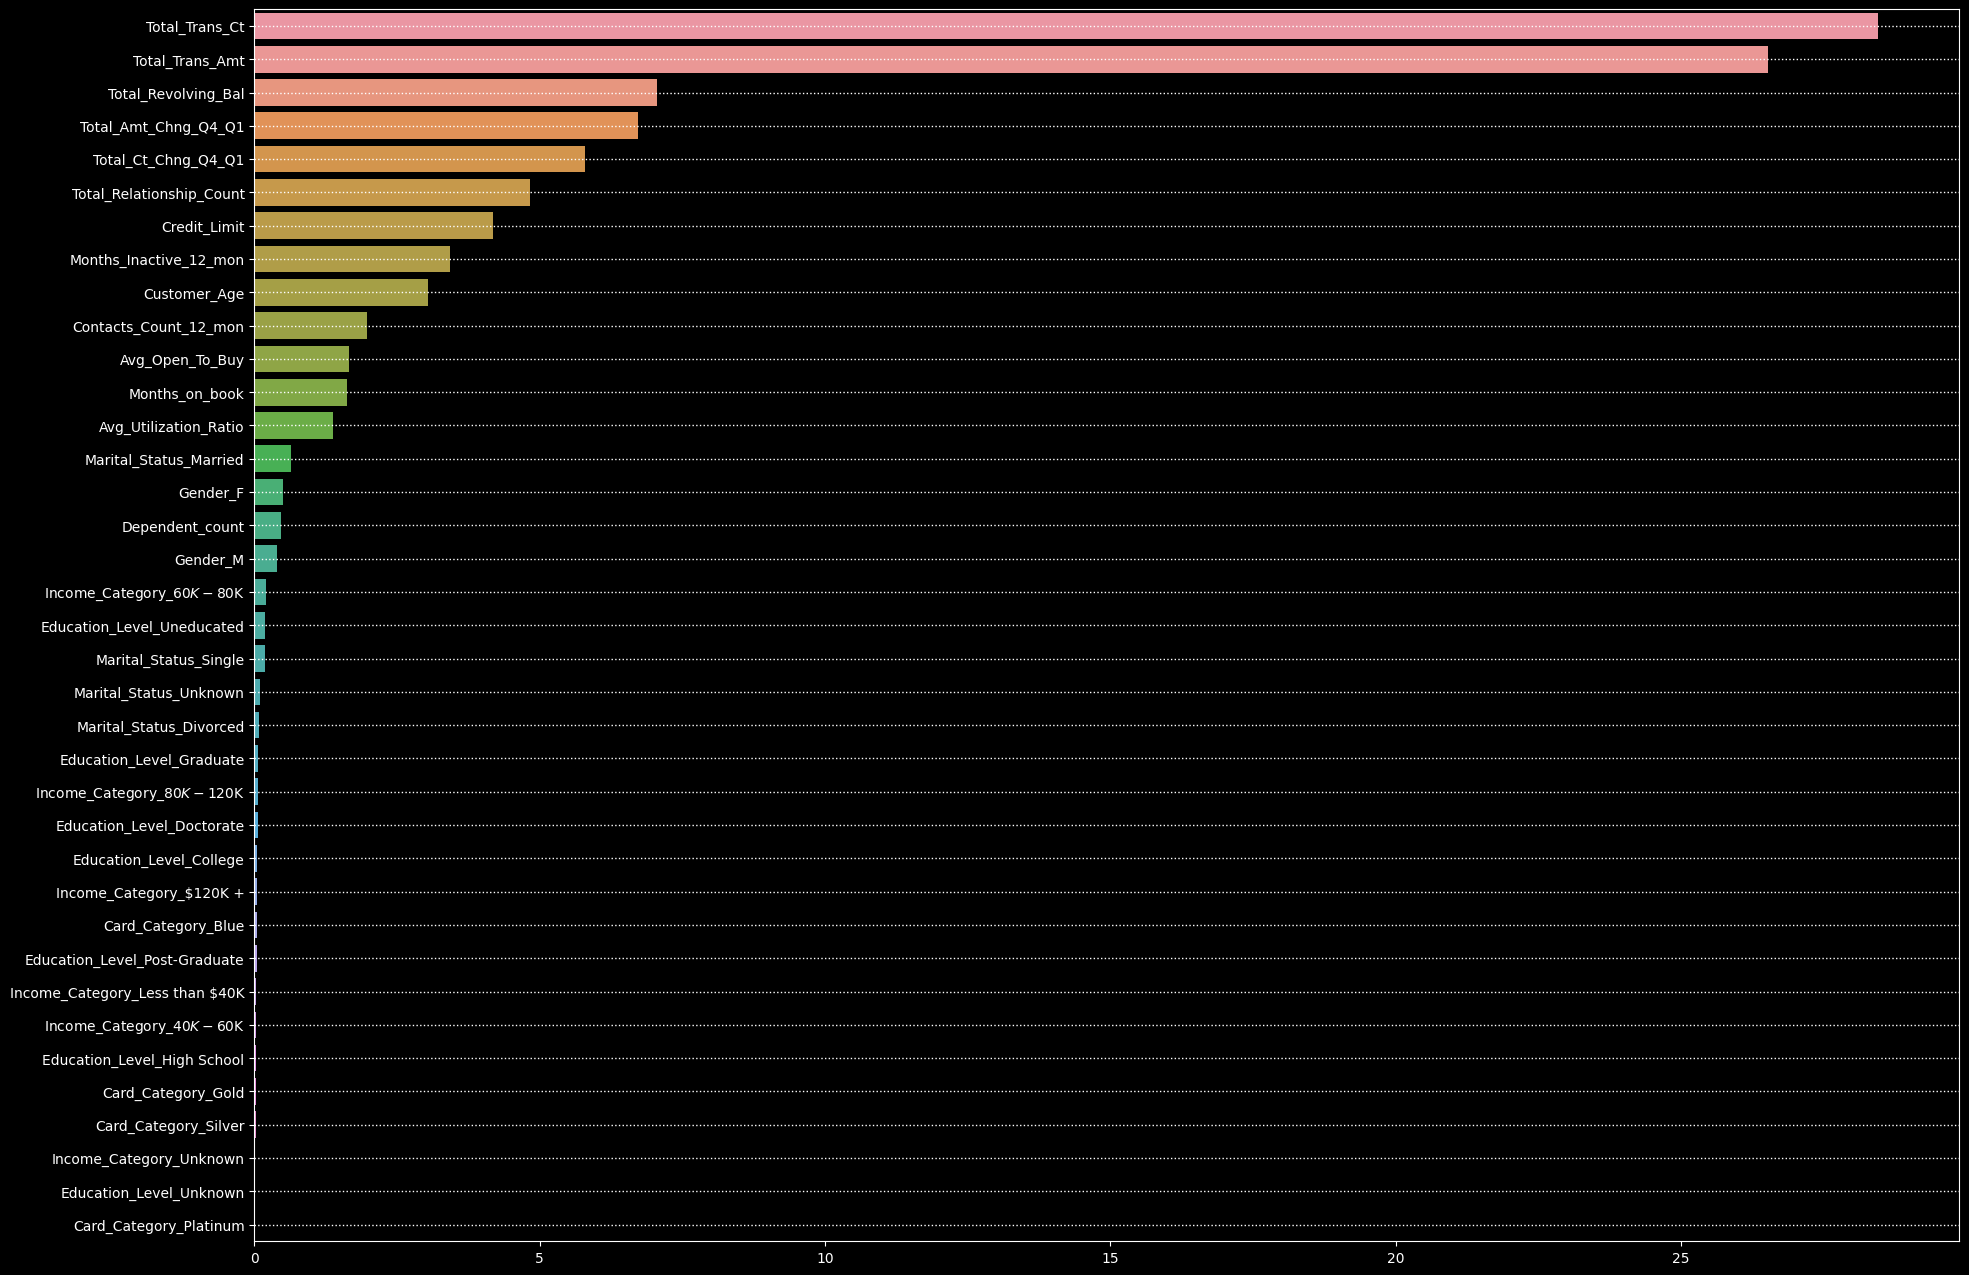

In [7]:
importances = pd.DataFrame(model_fitted.feature_importances_.reshape(1,-1), columns=X_train.columns)
plt.figure(figsize=(22,16))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

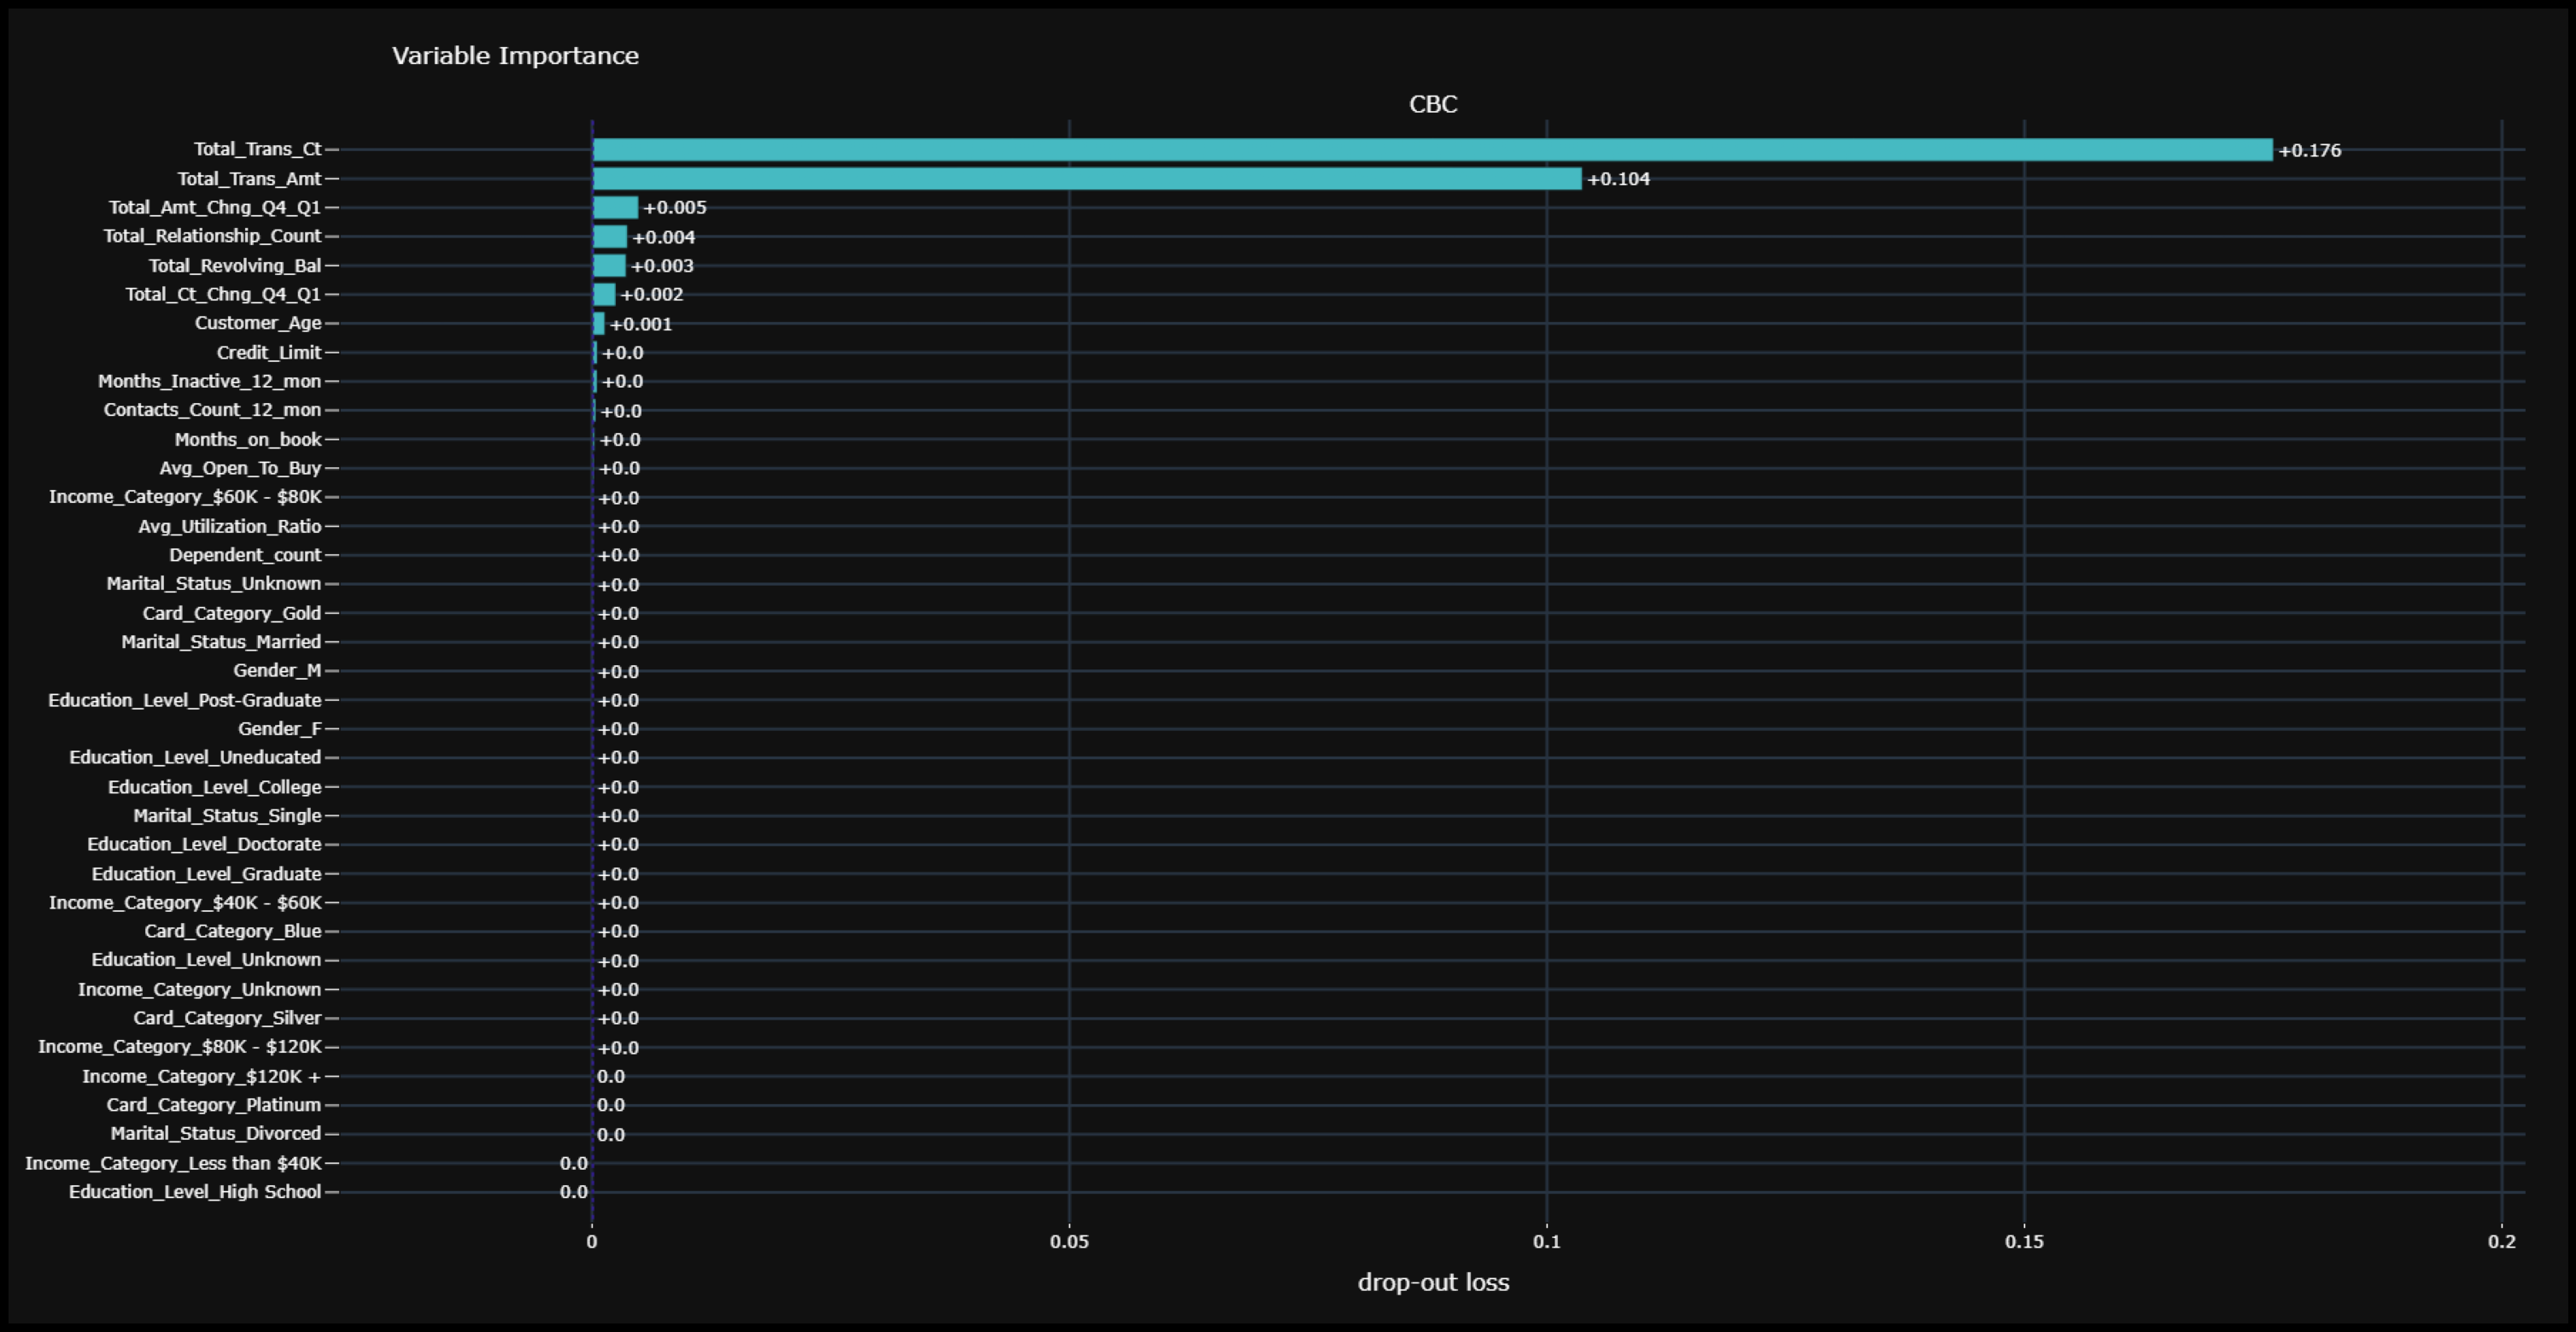

In [8]:
#permutation-based importances
model_exp_importances = model_exp.model_parts()
#dynamic plot
#model_exp_importances.plot(max_vars=None, show=False).update_layout(template='plotly_dark', font_color='white')

#displaying static plot (to make it visible in github)

img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/importances.png")
plt.figure(figsize=(50,20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Next step is dropping all the features which are least important from the above plot.

In [9]:
model_exp_importances.result = model_exp_importances.result[~model_exp_importances.result['variable'].isin(['_baseline_', '_full_model_'])].drop(columns='label').sort_values(by=['dropout_loss'], ascending=False)
permutation_based_importances = model_exp_importances.result.T
permutation_based_importances.columns = permutation_based_importances.iloc[0]
permutation_based_importances.drop(permutation_based_importances.index[0], inplace=True)

In [10]:
permutation_based_importances = permutation_based_importances.applymap(lambda x: x if x>=0.0002 else 0)
permutation_based_importances = permutation_based_importances.loc[:, (permutation_based_importances != 0).all(axis=0)]

Let's drop features which are the least important from feature importances plot.  
I set the importance threshhold to 0.2980692275 (so I drop every feature below Marital_Status_Single from the barplot).

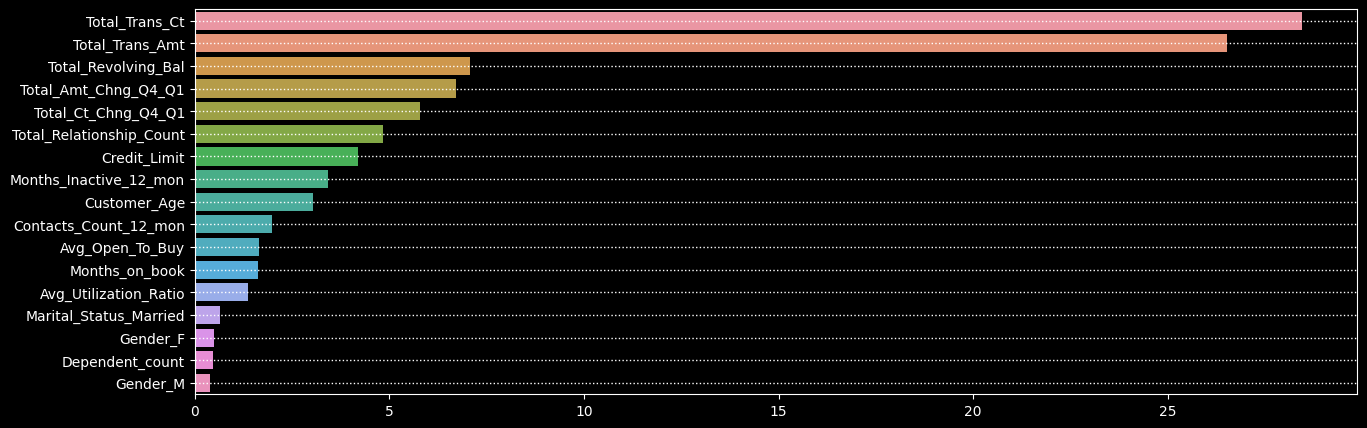

In [11]:
importances = importances.applymap(lambda x: x if x>=0.2980692275 else 0)
importances = importances.loc[:, (importances != 0).all(axis=0)]
plt.figure(figsize=(15,5))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

In [12]:
X_train1, X_val1, X_test1 = X_train[importances.columns], X_val[importances.columns], X_test[importances.columns]

In [13]:
fitted_reduced_model1 = model.fit(X_train1, y_train)
y_pred1 = fitted_reduced_model1.predict(X_val1)

In [14]:
X_train2, X_val2, X_test2 = X_train[permutation_based_importances.columns], X_val[permutation_based_importances.columns], X_test[permutation_based_importances.columns]

In [15]:
fitted_reduced_model2 = model.fit(X_train2, y_train)
y_pred2 = fitted_reduced_model2.predict(X_val2)

In [16]:
print('Model 0: ', roc_auc_score(y_pred, y_val))
print('Model 1: ', roc_auc_score(y_pred1, y_val))
print('Model 2: ', roc_auc_score(y_pred2, y_val))

Model 0:  0.965912819350627
Model 1:  0.9670569408160196
Model 2:  0.9680082559339526


Model with the least explanatory variables (12) has really similar ROC AUC score as the most complex one (model 0 with 37 variables) and first one (with 17 variables).\
Hence, to simplify further analysis model 2 should be chose - to improve its performance tuning of hyperparameters should be done.

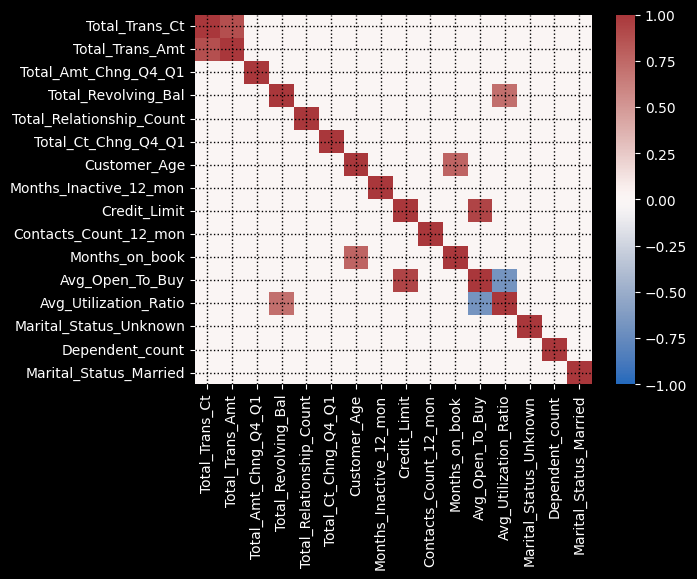

In [17]:
corr_mat = X_train2.corr('spearman', numeric_only=True)
corr_mat[np.abs(corr_mat) < 0.5] = 0
sns.heatmap(corr_mat, cmap="vlag", vmin=-1)
plt.grid(lw=1, color='black', linestyle='dotted')
plt.show()

From correlation matrix there are pairs of features which are strongly correlated:  
Months_On_Book and Customer_Age  
Total_Trans_Ct and Total_Trans_Amt  
During interpreting results dependences can be inaccurate in case of those particular features, but they are too important to drop them.

In [18]:
#defining objective function (it returns auc on a validation set)

def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.5, log=True),
        "depth": trial.suggest_int("depth", 1, 6),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 10),
        "random_strength": trial.suggest_float("random_strength", 0, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        X_train2,
        y_train,
        verbose=0,
        eval_set=[(X_val2, y_val)],
        early_stopping_rounds=100,
        callbacks=[pruning_callback]
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(X_val2)
    auc = roc_auc_score(y_val, preds)

    return auc

In [19]:
import warnings
warnings.filterwarnings("ignore")

#searching for hyperparameters which maximize auc function
study = optuna.create_study(direction="maximize")

#setting verbosity to show only the best result (not every particular trial)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=1000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

warnings.filterwarnings('default')

[I 2023-04-27 18:46:05,249] A new study created in memory with name: no-name-325f27f9-d4a4-438e-ba29-a2800bf1c212


Number of finished trials:  1000
Best trial:
  Value: 0.9497340562207718
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.3780549784819064
    depth: 6
    l2_leaf_reg: 5
    random_strength: 0.16751747062340822
    boosting_type: Plain
    bootstrap_type: MVS


In [20]:
#checking the optimized model's performance

optimized_model = CatBoostClassifier(iterations=850, verbose=False, **trial.params).fit(X_train2, y_train)
y_pred_opt = optimized_model.predict(X_val2)
print('Metrics on a validation set: ')
print('Precision: ', precision_score(y_pred_opt, y_val))
print('Recall: ', recall_score(y_pred_opt, y_val))
print('F1 score: ', f1_score(y_pred_opt, y_val))
print('Accuracy: ', accuracy_score(y_pred_opt, y_val))
print('AUC: ', roc_auc_score(y_pred_opt, y_val))

Metrics on a validation set: 
Precision:  0.9057377049180327
Recall:  0.9567099567099567
F1 score:  0.9305263157894736
Accuracy:  0.9782894736842105
AUC:  0.9694333336691754


In [21]:
#ensuring there isn't an overfitting problem in optimized model by doing cross-validation

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=999)
cv_results = cross_validate(optimized_model, X_train, y_train, scoring='roc_auc', cv=cv, return_train_score=True)

#checking discrepancy between train and validation results

print('Performance on a train set: ', cv_results['train_score']*100, '%')
print('Performance on a validation set: ', cv_results['test_score']*100, '%')
print('Differences: ', (cv_results['train_score']-cv_results['test_score'])*100, 'percentage points')

Performance on a train set:  [99.99774101 99.99880406 99.99877246 99.99893695 99.99813965 99.99960188
 99.99916949 99.99880406 99.99694774 99.99920271 99.99906983 99.9990047
 99.99784067 99.99960135 99.99807575 99.99913627 99.99717626 99.99903787
 99.99744203 99.99953491 99.99877246 99.99860474 99.99920271 99.9991374
 99.99946847 99.99787389 99.99917058 99.99754169 99.99900339 99.99990047] %
Performance on a validation set:  [99.32744114 99.28404597 99.37955471 99.10940361 99.39843937 99.30477662
 99.19168193 99.47235714 99.21323333 99.07556334 99.42033601 99.34935075
 99.27011174 99.14045704 99.38381254 99.24741885 99.1052897  99.51380933
 99.38596491 99.39751042 99.1171661  99.32120392 99.09984871 99.40909339
 99.27727791 99.42086684 99.09321582 99.4945192  99.35106298 98.96428348] %
Differences:  [0.67029986 0.71475809 0.61921775 0.88953333 0.59970029 0.69482526
 0.80748756 0.52644692 0.78371441 0.92363937 0.57873381 0.64965395
 0.72772893 0.85914431 0.61426321 0.75171742 0.89188656

Differences between train and validation sets are realtively low, so there is not an overfitting problem.

In [22]:
#initializing explainer for chosen model (model analysis will be done on a validation set)
model2_exp = dx.Explainer(optimized_model, X_val2, y_val, label='CBC-optimized')

Preparation of a new explainer is initiated

  -> data              : 1520 rows 16 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1520 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : CBC-optimized
  -> predict function  : <function yhat_proba_default at 0x000001E21115E050> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 8.41e-06, mean = 0.156, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.979, mean = 0.00502, max = 0.99
  -> model_info        : package catboost

A new explainer has been created!


Checking residuals - there should be no pattern in residuals.  
Otherwise, it means that model is biased - it overestimates or underestimates predictions.

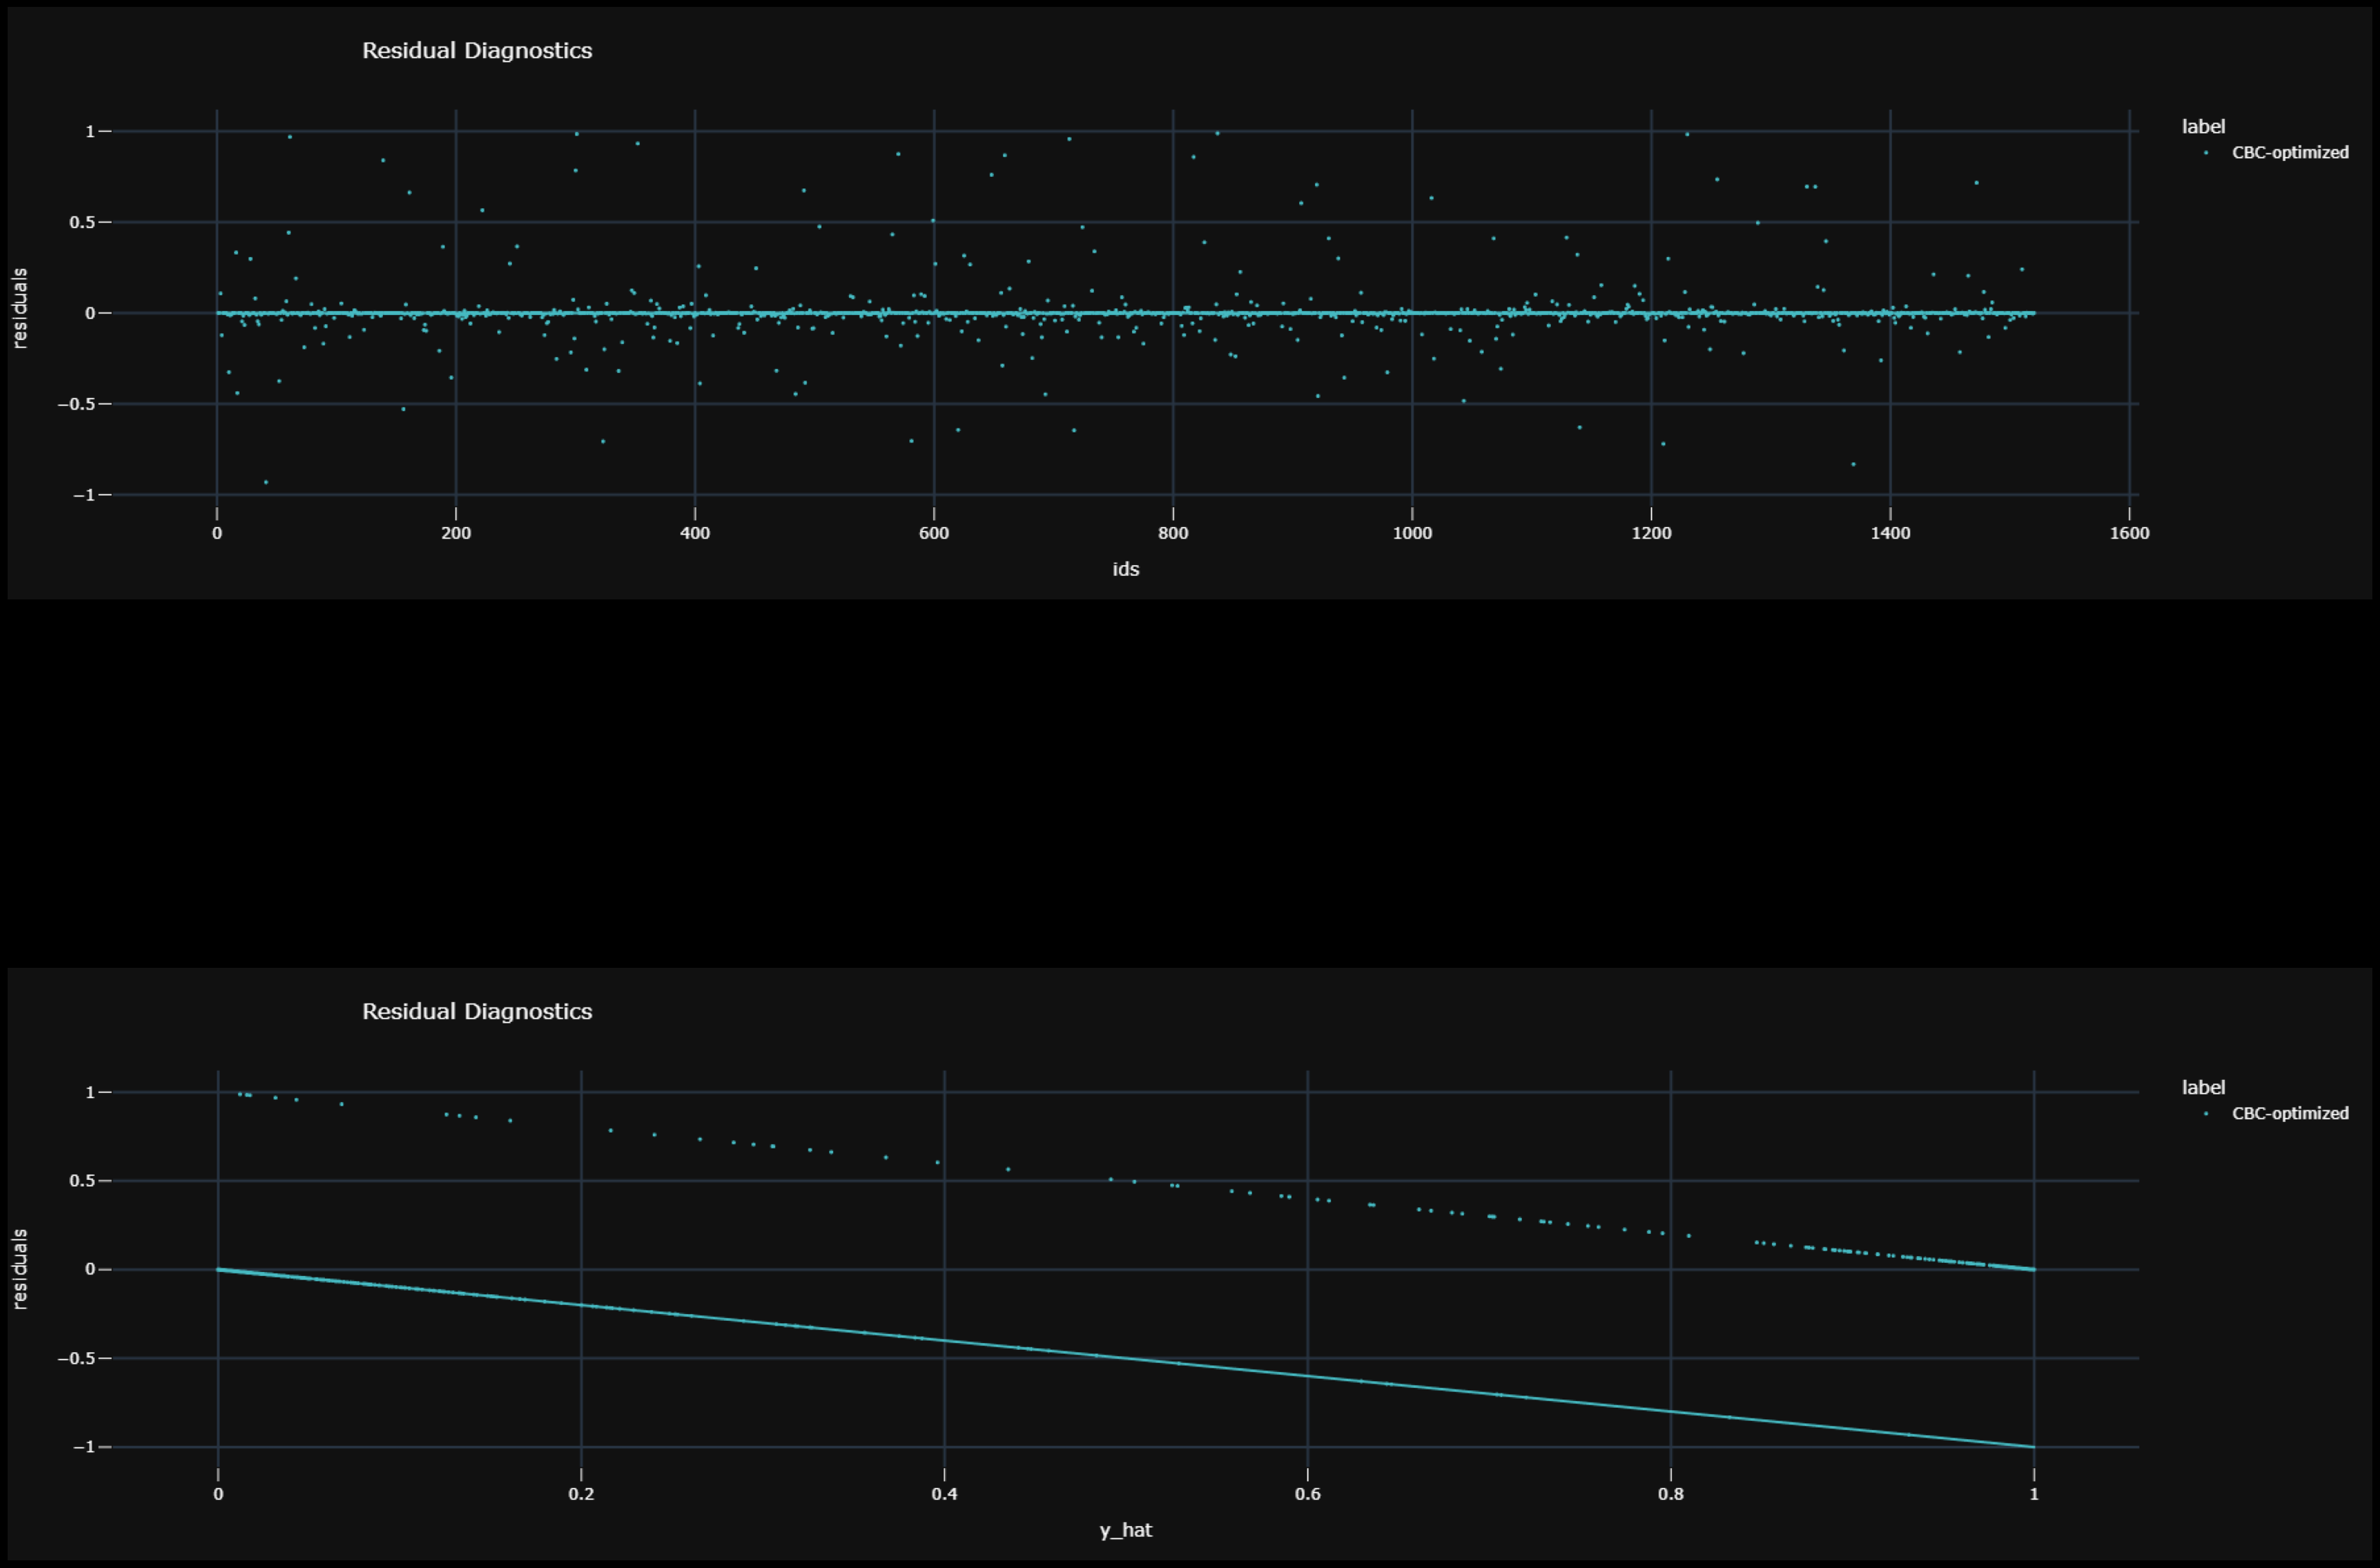

In [23]:
#residuals' plot 
model_exp_diagnostic = model2_exp.model_diagnostics()

#dynamic plots
#model_exp_diagnostic.plot(variable='ids', yvariable='residuals', show=False).update_layout(template='plotly_dark', font_color='white').show()
#model_exp_diagnostic.plot(variable='y_hat', yvariable='residuals', show=False).update_layout(template='plotly_dark', font_color='white')

#displaying static plots

img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/residuals1.png")
img2 = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/residuals2.png")
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
imgplot = plt.imshow(img)
plt.axis('off')
plt.subplot(2,1,2)
imgplot2 = plt.imshow(img2)
plt.axis('off')
plt.show()

Second plot indices that the higher predicted value(y_hat) is, the more negative residuals are.  
It means, that model is better at predicting zeros than ones (compare precision and recall above - recall is higher).

Calculating ceteris paribus: 100%|██████████| 16/16 [00:00<00:00, 53.84it/s]


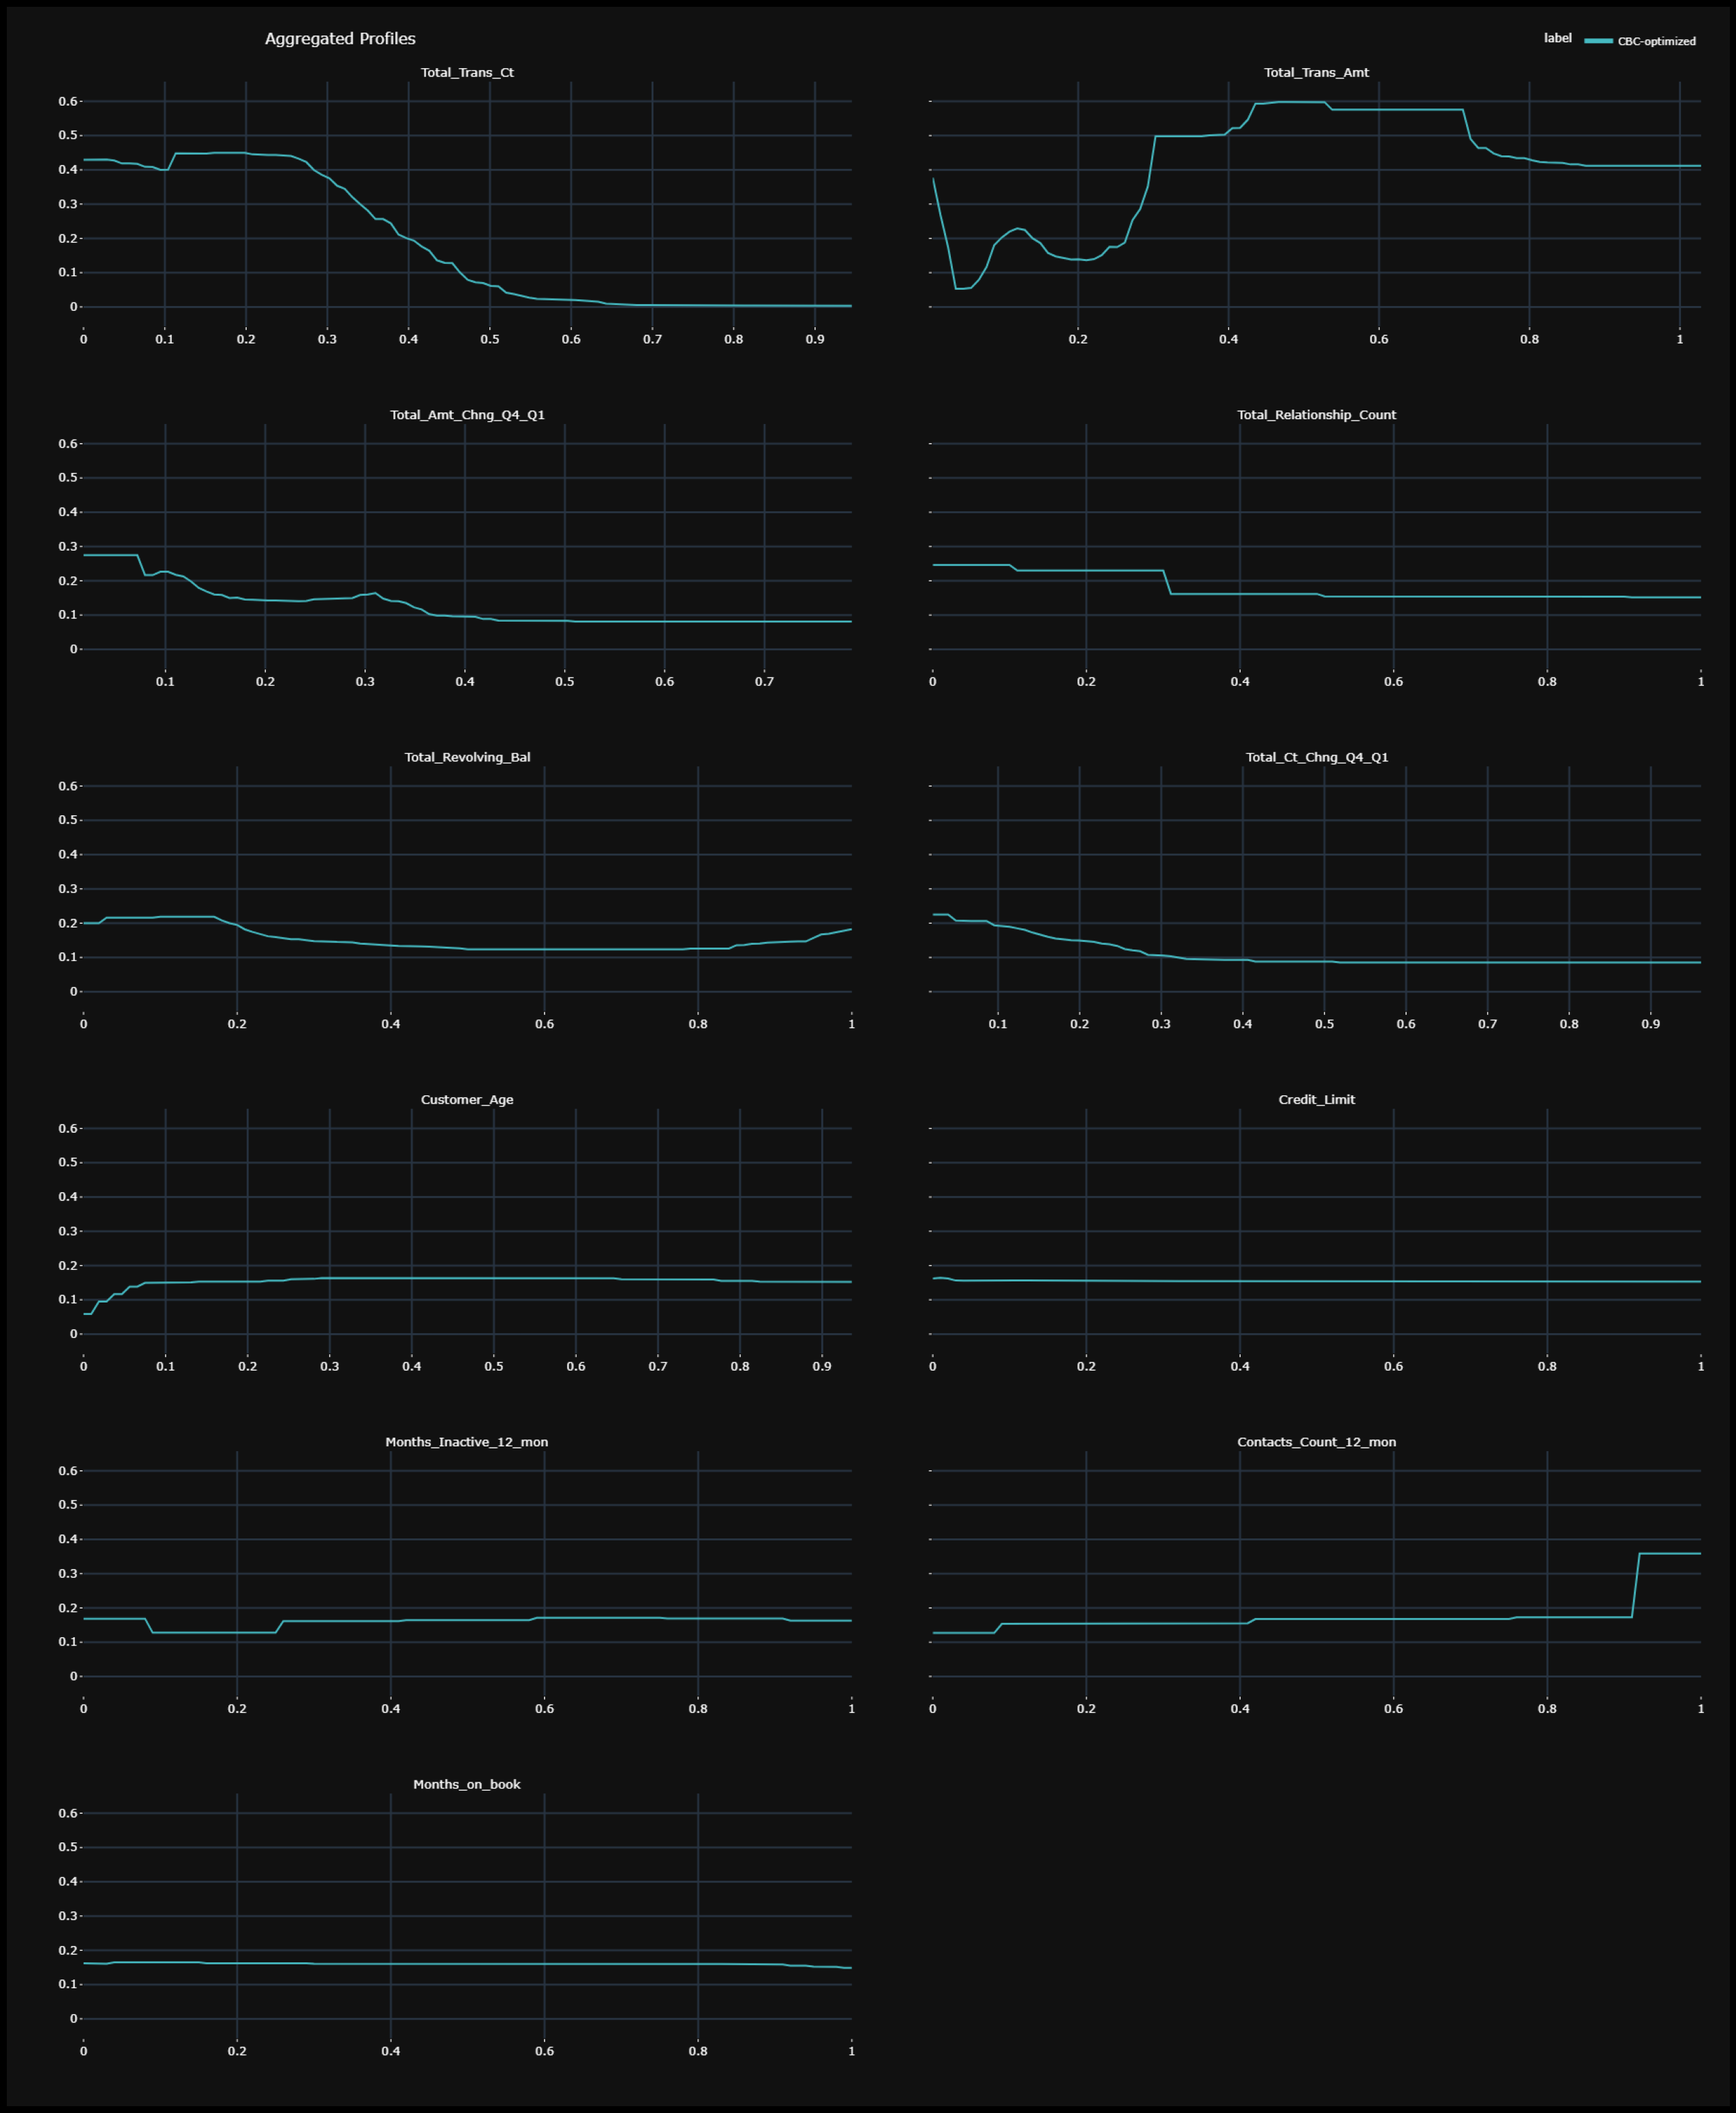

In [24]:
#partial dependence
model_exp_PD = model2_exp.model_profile()
#dynamic plot
#model_exp_PD.plot(show=False).update_layout(template='plotly_dark', font_color='white')

#static plot

img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/partial_dependences.png")
plt.figure(figsize=(40,40))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Comments about particular variables influence on a risk of attrition:<br><br>
Total transaction count - the more transactions are done, the less chance for a churn. It means that if someone does a lot of transactions in a bank, he/she is less eager to change his/her bank.\
Total transaction amount - dependence is irregular and it is not accurate, because this variable is correlated with the first one. However it makes the model worse in a case of interpretability, this variable is too important for model's performance. Hence, variable is in a model and it 'corrects' first variable's influence (look at its irregular distribution).\
Change of amount - it leads to the situation that customer is less eager to churn. If someone increases amount in a bank account, he/she rather not consider changing a bank.\
Total relationship - regular clients also do not want to leave a bank, where they have been for a long time.\
Revolving balance - it is a total amount of loan. There is a U-shape relationship, so at the beginning the amount of debt does not affect the risk of churn. When the value of the debt is higher, this risk becomes lower and lower, and after exceeding a certain amount of debt the risk of churn is higher. It's maybe because of a fact that too big loan can lead to insolvency and as a result to leaving a bank (of course the process is then more complicated).\
Change of transactions count - as a change of amount, it leads to the situation that customer is less eager to churn. If someone increases number of transactions in a bank account, he/she rather not consider changing a bank.\
Customer age - the higher age, the risk of churn is also higher at the beggining, but then it has no influence. It is also worth noticing that older people are more eager to stay in a bank.\
Credit limit - it has really low influence, but for really low values increasing a limit leads to a small drop of a churn risk (then it has no influence).\
Other variables has a low influence.

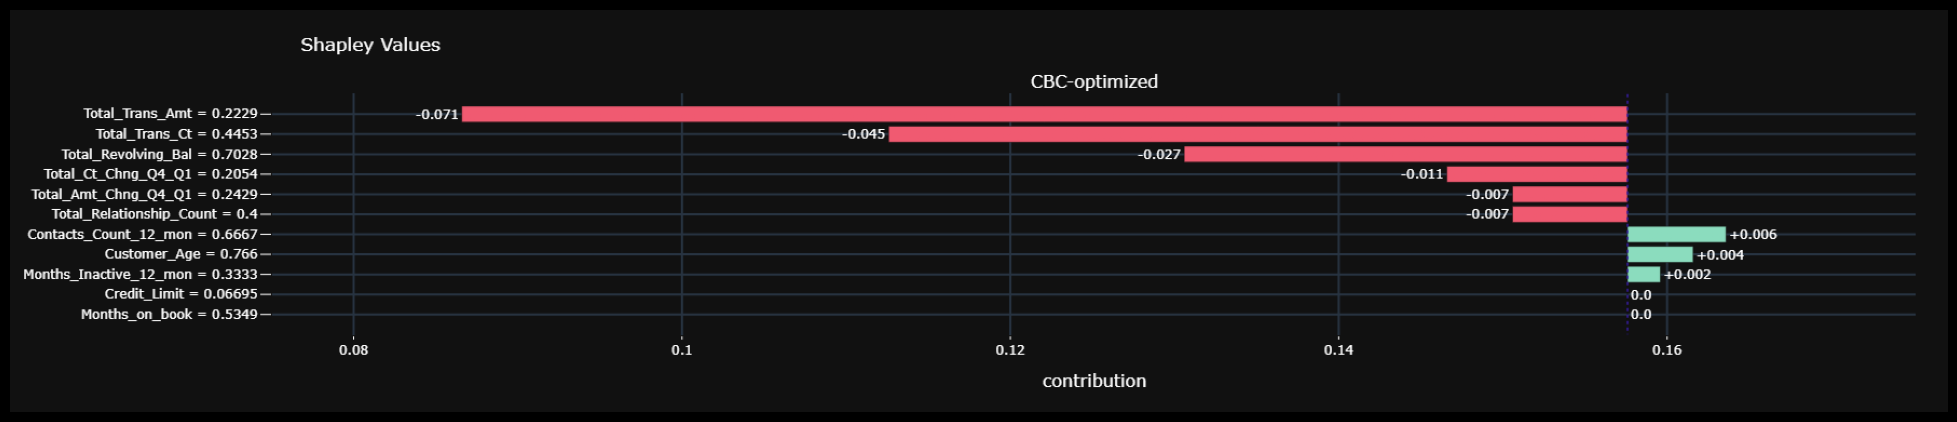

In [25]:
single_datapoint = X_val2.sample(random_state=42)
shap = model2_exp.predict_parts(single_datapoint, type = 'shap')
#dynamic plot
#shap.plot(max_vars=20, show=False).update_layout(template='plotly_dark', font_color='white')

#static plot
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/shapley.png")
plt.figure(figsize=(25,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Here it is seen an influence for a particular datapoint.

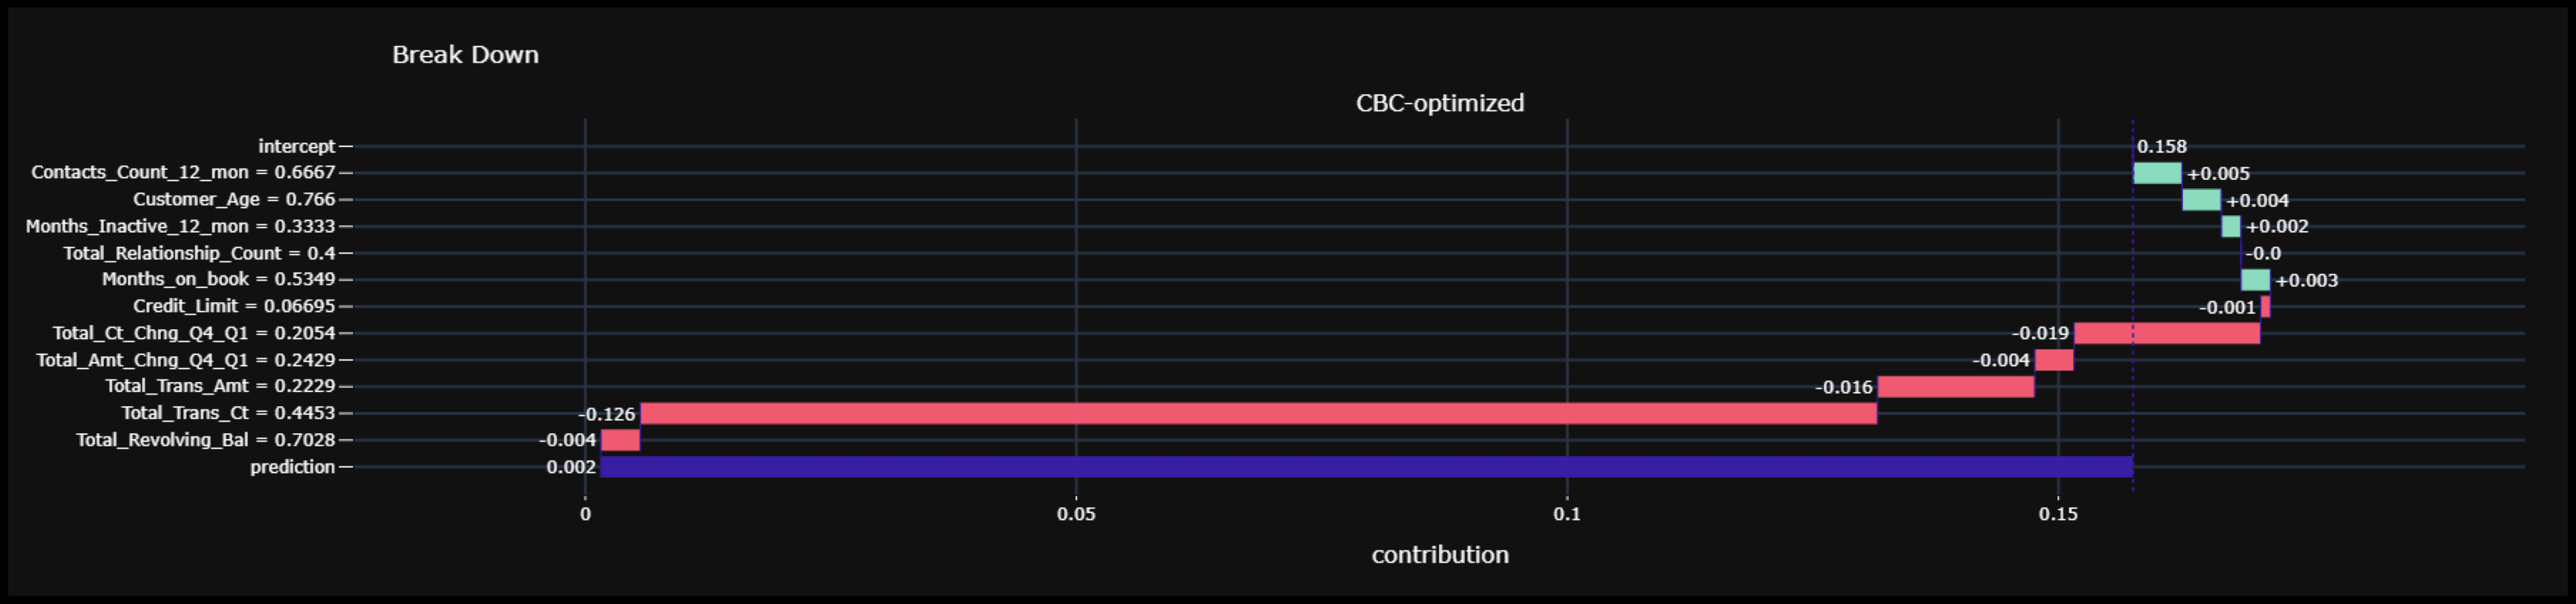

In [26]:
model_exp_bd = model2_exp.predict_parts(single_datapoint, type='break_down')
#dynamic plot
#model_exp_bd.plot(max_vars=20, show=False).update_layout(template='plotly_dark', font_color='white')

#static plot
img = mpimg.imread("C:/Users/pc/Churn-Classification/Static_Plots/break_down.png")
plt.figure(figsize=(40,20))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
#final models' performance on a test set should be checked

y_pred_opt = optimized_model.predict(X_test2)
print('Metrics on a test set: ')
print('Precision: ', precision_score(y_pred_opt, y_test))
print('Recall: ', recall_score(y_pred_opt, y_test))
print('F1 score: ', f1_score(y_pred_opt, y_test))
print('Accuracy: ', accuracy_score(y_pred_opt, y_test))
print('AUC: ', roc_auc_score(y_pred_opt, y_test))

Metrics on a test set: 
Precision:  0.9262295081967213
Recall:  0.9495798319327731
F1 score:  0.9377593360995851
Accuracy:  0.9802501645819618
AUC:  0.9677641548422647


Results on a test set are really similar as results for a validation set and AUC score is relatively high, so model's performance is really satisfactory.